In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.sensitivity import get_sensitivity
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

from wrappers import *

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_31349/1702327502.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


# lisatools Tutorial

## Diagnostics

Setup all snr calculators

In [2]:
# black hole generator
bbh = BBHTemplateGen()

# gb generator
gb = GBTemplateGen()

# emri generator
emri = EMRITemplateGen(
    "FastSchwarzschildEccentricFlux",  # will ignore spin and inclination (or change to Pn5AAKWaveform)
    "../../lisa-on-gpu/orbit_files/esa-trailing-orbits.h5",
)

# psd info
psd_kwargs = dict(
    model="SciRDv1",  # can be SciRDv1, MRDv1, sangria
    includewd=1,  # Years of observation so far
)
fn = np.logspace(-6, -1, 1000)  # for plotting
Sn = get_sensitivity(fn, sens_fn="noisepsd_AE", **psd_kwargs)  # for plotting

bbh_snr_calc = CalculateSNR(bbh, psd_kwargs)
gb_snr_calc = CalculateSNR(gb, psd_kwargs)
emri_snr_calc = CalculateSNR(emri, psd_kwargs)

Tobs = YRSID_SI
dt = 10.0
Nobs = int(Tobs / dt)
Tobs = Nobs * dt
df = 1 / Tobs


/Users/mlkatz1/miniconda3/envs/lisa_snr_env/lib/python3.12/site-packages/few/utils/utility.py:793: UserWarning: The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location.
  warnings.warn(
--2024-01-25 15:39:11--  https://zenodo.org/record/3981654/files/FluxNewMinusPNScaled_fixed_y_order.dat
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3981654/files/FluxNewMinusPNScaled_fixed_y_order.dat [following]
--2024-01-25 15:39:12--  https://zenodo.org/records/3981654/files/FluxNewMinusPNScaled_fixed_y_order.dat
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 61494 (60K) [application/octet-stream]
Saving to: ‘FluxNewMinusPNScaled_fixed_y_order.dat’

     0K .......... .......... ......

### MBHBs

In [3]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

snr_val = bbh_snr_calc(*mbh_injection_params)

(1e-19, 5.748793819007112e-15)

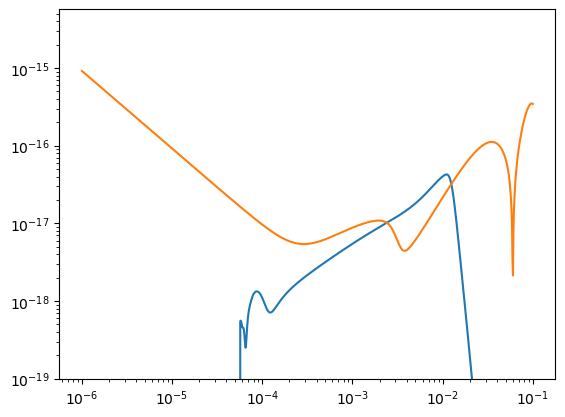

In [4]:
plt.loglog(bbh_snr_calc.f_arr, np.abs(bbh_snr_calc.last_output[0]))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))
plt.ylim(1e-19,)

### EMRIs

In [5]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)


emri_snr_val = emri_snr_calc(*emri_injection_params)



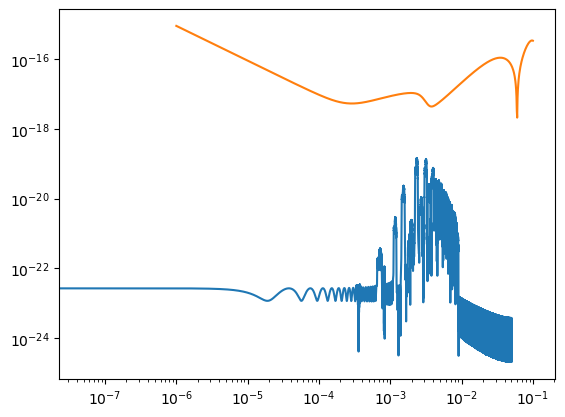

In [6]:
freqs = np.fft.rfftfreq(emri_snr_calc.last_output[0].shape[0], dt)
plt.loglog(freqs, np.abs(np.fft.rfft(emri_snr_calc.last_output[0]) * dt))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))

### GBs

In [7]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])

gb_snr_val = gb_snr_calc(*gb_injection_params)
print(gb_snr_val)

231.75477265092368


(1e-06, 1.0)

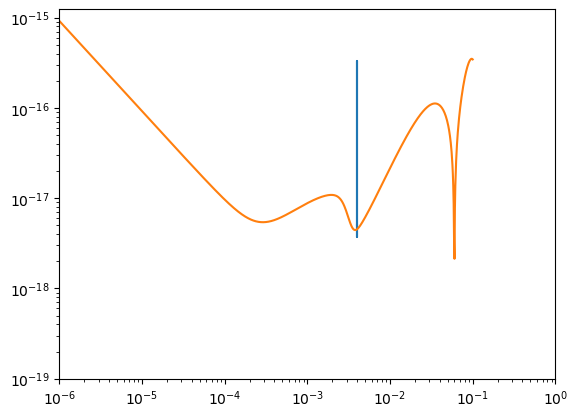

In [8]:
plt.loglog(gb_snr_calc.f_arr, np.abs(gb_snr_calc.last_output[0]))
plt.loglog(fn, (Sn / (4 * df)) ** (1/2))
plt.ylim(1e-19,)
plt.xlim(1e-6, 1e0)

#### VGBS Specifically

In [9]:
vgbs = pd.read_csv("vgbs.txt")

b'HPLib' 28.31207526465955
b'ZTFJ2320' 0.30401512401496444
b'SDSSJ0923' 4.237257162958358
b'AMCVn' 48.17104304371236
b'CX1751' 3.323028772425761
b'ZTFJ2029' 2.537650673595041
b'SDSSJ0935' 29.740892139225974
b'ZTFJ1539' 86.38881131278164
b'SDSSJ2322' 14.055157402644529
b'4U1820-30' 6.113253883762025
b'HMCnc' 144.97593113653897
b'CRBoo' 13.885189903611131
b'PTFJ0533' 3.9685787572515605
b'HD265435' 2.540320818971473
b'CDm30' 3.897892418189185
b'ZTFJ0640' 0.4364788142403734
b'ZTFJ1749' 2.2585209615156034
b'SMSSJ0338' 4.603350847598435
b'SDSSJ1630' 3.4679432079526356
b'ZTFJ2055' 0.5198095020170093
b'ZTFJ1901' 1.6249264624793067
b'ZTFJ1946' 0.7115330482874752
b'ESCet' 74.40617214016939
b'SDSSJ1337' 4.887716339936895
b'ZTFJ2130' 1.6663709769592636
b'V407Vul' 104.1951713492843
b'ZTFJ2243' 76.08876548896808
b'SDSSJ0634' 15.328333193122047
b'ZTFJ0722' 4.997638686221978
b'PTF1919' 2.3299253538557476
b'V803Cen' 16.71019385796335
b'SDSSJ1351' 9.82966034407025
b'SDSSJ1235' 4.163517094559483
b'ZTFJ05

(1e-06, 1.0)

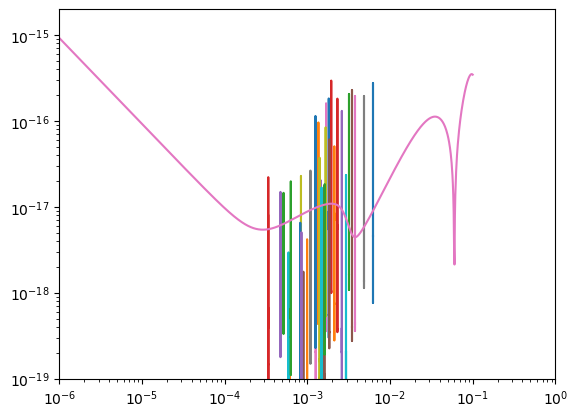

In [10]:
for i in range(len(vgbs)):
    vgb = vgbs.iloc[i]
    params_in = np.array([
        vgb["Amplitude"],
        vgb["Frequency"],
        vgb["FrequencyDerivative"],
        0.0,
        vgb["InitialPhase"],
        vgb["Inclination"],
        vgb["Polarization"],
        vgb["EclipticLongitude"],
        vgb["EclipticLatitude"]
    ])

    snr_here = gb_snr_calc(*params_in)
    plt.loglog(gb_snr_calc.f_arr, np.abs(gb_snr_calc.last_output[0]))
    print(vgb["Name"], snr_here)

plt.loglog(fn, (Sn / (4 * df)) ** (1/2))
plt.ylim(1e-19,)
plt.xlim(1e-6, 1e0)